Importing modules

In [1]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt

Loading datasets

In [2]:
#(xTrain,yTrain),(xTest,yTest)=tf.keras.datasets.mnist.load_data()
(xTrain,yTrain),(xTest,yTest)=tf.keras.datasets.fashion_mnist.load_data()

Preprocessing functions

In [3]:
def preprocData(dSet):
    dSetRes=dSet.reshape(dSet.shape[0],-1).T/255.0
    dSetMean=np.mean(dSetRes,axis=1).reshape(-1,1)
    return(dSetRes,dSetMean)
xTrainPreproc,trainSetMean=preprocData(xTrain)
xTrainPreproc-=trainSetMean
xTestPreproc,_=preprocData(xTest)
xTestPreproc-=trainSetMean

Class definition for orthogonal transform training

In [4]:
class sparseOrthoTransformTrainer:
    def __init__(self,trainData,spp,numIter,dictInit=None):
        if(dictInit is None):
            randSel=np.random.RandomState(2500).permutation(xTrainPreproc.shape[1])[:1001]
            dictInit,_,_=np.linalg.svd(xTrainPreproc[:,randSel])
        self.spp=spp
        self.err=np.zeros((numIter,1))
        self.trainData=trainData
        self.dict=dictInit
        self.numIter=numIter
    def spCode(self):
        proj=self.dict.T@self.trainData
        proj_s=np.sort(np.abs(proj),axis=0)[-self.spp,:]
        proj=proj*(np.abs(proj)>=proj_s)
        self.proj=proj
    def dictUpdate(self):
        mat=self.proj@self.trainData.T
        u,_,v=np.linalg.svd(mat)
        self.dict=v.T@u.T
    def fitDict(self,dispInt=0):
        print('Training')
        for i in range(self.numIter):
            self.spCode()
            self.err[i]=np.mean((self.trainData-self.dict@self.proj)**2)
            if(i%dispInt==0):
                print(f'Iteration:{i} Error:{self.err[i][0]:0.4f}')
            self.dictUpdate()
 
spp=70
numIter=100
TrainDict=sparseOrthoTransformTrainer(xTrainPreproc,spp,numIter)
TrainDict.fitDict(dispInt=10)

Training
Iteration:0 Error:0.0072
Iteration:10 Error:0.0050
Iteration:20 Error:0.0043
Iteration:30 Error:0.0039
Iteration:40 Error:0.0037
Iteration:50 Error:0.0035
Iteration:60 Error:0.0034
Iteration:70 Error:0.0034
Iteration:80 Error:0.0033
Iteration:90 Error:0.0033


Display learned transform

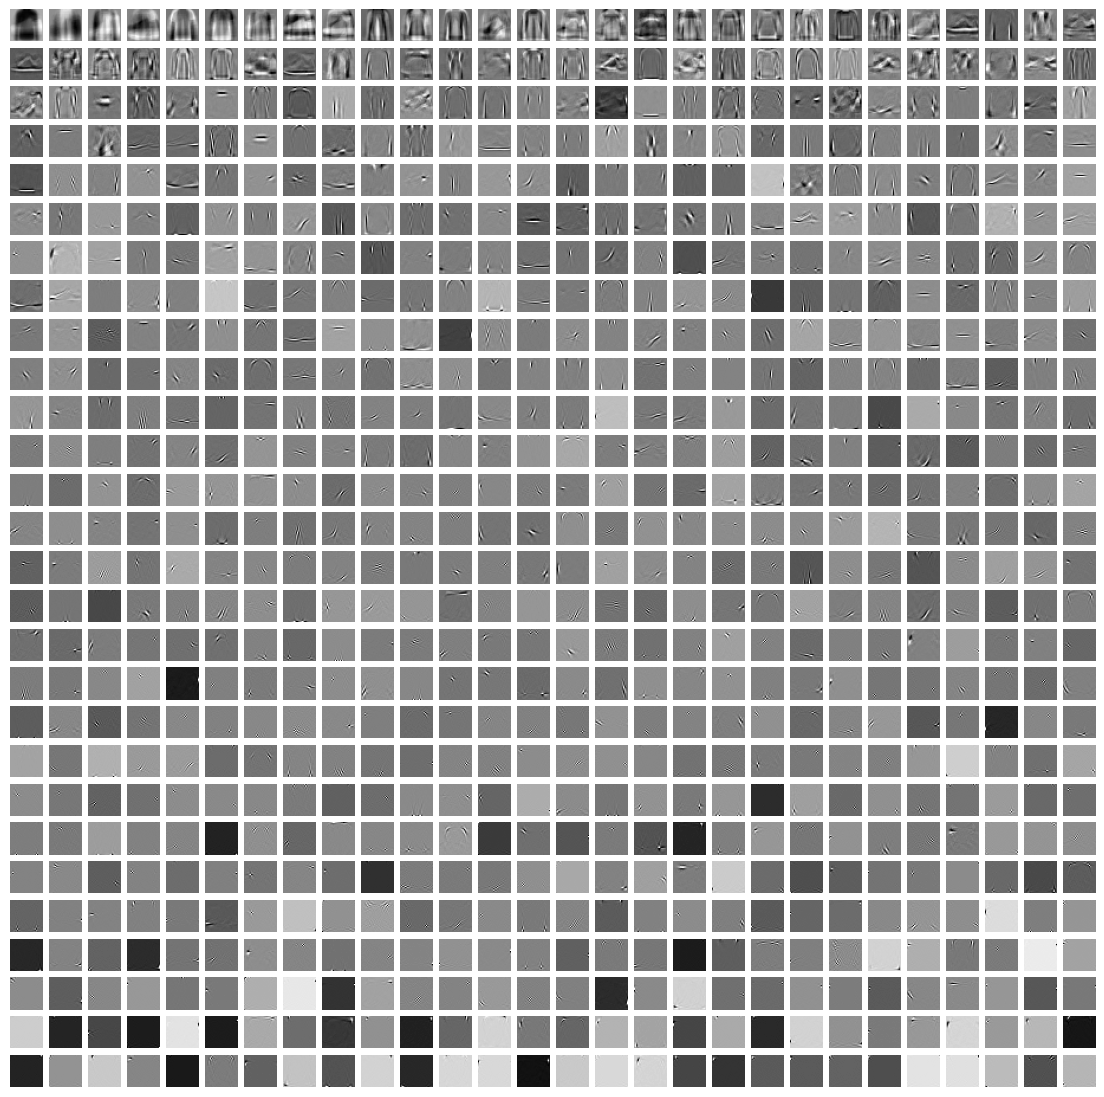

In [5]:
fig,ax=plt.subplots(nrows=xTrain.shape[1],ncols=xTrain.shape[2],figsize=(14,14))
k=0
for i in range(28):
    for j in range(28):
        ax[i,j].imshow(TrainDict.dict[:,k].reshape(xTrain.shape[1],xTrain.shape[2]),cmap='gray')
        ax[i,j].axis('off')
        k+=1
plt.savefig('Visualized_learned_dictionary_FashionMNISTspp70.svg',format='svg',dpi=300)

Reconstruct data

In [6]:
def reconstructData(TrainDict,trainSetMean):
    reconData=(TrainDict.dict@TrainDict.proj+trainSetMean)
    reconData*=reconData>=0.0 # renormalizing between 0 and 255
    reconData=(reconData/np.max(reconData,axis=0))*255.0
    return reconData

Compare reconstruction with original

In [7]:
def showReconOrigComparison(reconData,trainData,ind):
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(14,7))
    ax[0].imshow(reconData[:,ind].reshape(28,28))
    ax[0].set_title('Reconstruction',fontsize=16,fontweight='bold')
    ax[1].imshow(trainData[ind,:,:])
    ax[1].set_title('Original',fontsize=16,fontweight='bold')


Display comparison

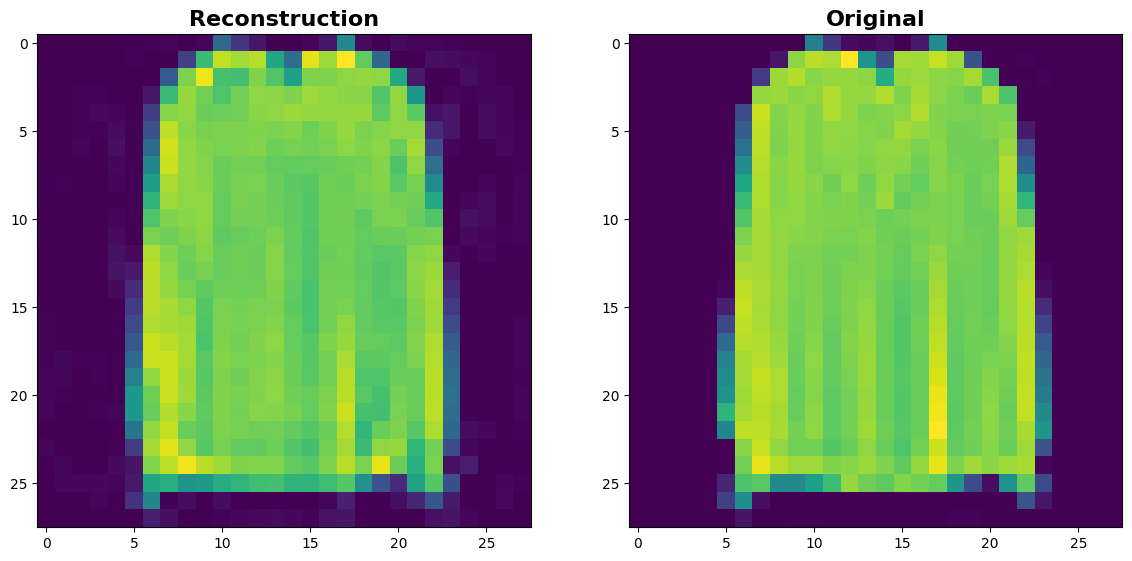

In [10]:
reconDataTrain=reconstructData(TrainDict,trainSetMean)
ind=np.random.randint(xTrain.shape[0])
showReconOrigComparison(reconDataTrain,xTrain,ind)
plt.savefig('Random_reconstructionFashionMNIST.svg',format='svg',dpi=300)